# Object Recognition with ALL-CNN
> In this project, it will show CNN model for object recognition. The Original Paper is "Striving for simplicity - The all convolutional net" from ICLR 2015.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Deep_Learning, Vision]
- image: images/cifar10_result.png

[This paper](https://arxiv.org/abs/1412.6806) introduced the convolutional neural network obtained state-of-the-art performance at object recognition on the CIFAR-10 image datasaet in 2015.

## Required Packages

In [26]:
import sys
import tensorflow as tf
from tensorflow.keras import utils

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image

plt.rcParams['figure.figsize'] = (8, 8)

## Version check

In [27]:
print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(np.__version__))
print('Pandas: {}'.format(pd.__version__))
print('Tensorflow: {}'.format(tf.__version__))

Python: 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Numpy: 1.18.1
Pandas: 1.0.1
Tensorflow: 2.1.0


## Prepare dataset
The original data is from [here](https://www.cs.toronto.edu/~kriz/cifar.html)

In [28]:
from tensorflow.keras.datasets import cifar10

# Load the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [68]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [30]:
# Determine the dataset characteristics
print("Training Images: {}".format(X_train.shape))
print("Test images: {}".format(X_test.shape))

Training Images: (50000, 32, 32, 3)
Test images: (10000, 32, 32, 3)


In [31]:
# A single image
print(X_train[0].shape)

(32, 32, 3)


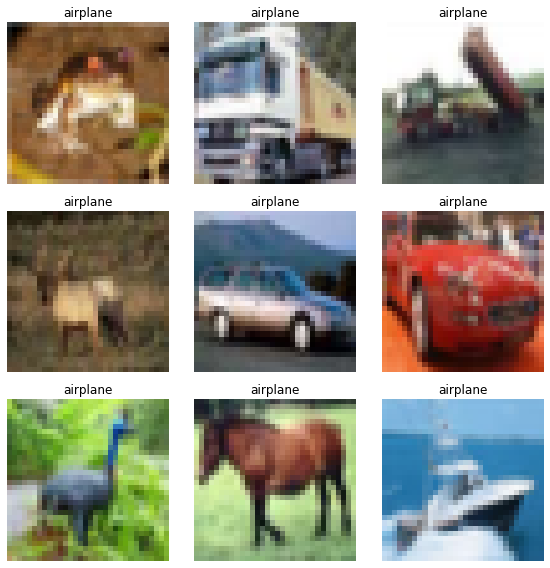

In [39]:
# Create a grid of 3x3 images
for i in range(9):
    plt.subplot(330 + 1 + i)
    img = X_train[i]
    plt.imshow(img)
    plt.title(labels[int(y_train[i][0])])
    plt.axis('off')
plt.tight_layout()

## Preprocess Data

In [35]:
# fix random seed for reproducibiliy
seed = 6
np.random.seed(seed)

# Normalize the inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.0
X_test /= 255.0

In [36]:
# Class labels shape
print(y_train.shape)
print(y_train[0])

(50000, 1)
[6]


In [37]:
# Convert the label with Onehot Encoder
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)
num_class = y_test.shape[1]

print(y_train.shape)
print(y_train[0])

(50000, 10)
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


## Building the All-CNN model
In this project, we`ll implement ALL-CNN-C model

- Input - 32 x 32 RGB image
- Layer Architecture
    - 3x3 conv. 96 ReLU
    - 3x3 conv. 96 ReLU
    - 3x3 max-pooling stride 2
    - 3x3 conv. 192 ReLU
    - 3x3 conv. 192 ReLU
    - 3x3 max-pooling stride 2
    - 3x3 conv. 192 ReLU
    - 1x1 conv. 192 ReLU
    - 1x1 conv. 10 ReLU
    - global averaging over 6x6 spatial dimensions
    - 10-way softmax

In [42]:
# import necessary layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Conv2D, Dense, GlobalAvgPool2D, MaxPool2D
from tensorflow.keras.optimizers import SGD

In [51]:
# Define the model function
def allcnn(weights=None):
    # define model type = Sequential
    model = Sequential()
    
    # Add model layer
    model.add(Conv2D(96, kernel_size=(3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'))
    model.add(Conv2D(96, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(3, 3), padding='same', strides=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(192, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(192, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPool2D(pool_size=(3, 3), padding='same', strides=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(192, kernel_size=(3, 3), padding='same', activation= 'relu'))
    model.add(Conv2D(192, kernel_size=(1, 1), padding='same', activation= 'relu'))
    model.add(Conv2D(10, kernel_size=(1, 1), padding='same', activation='relu'))
    
    model.add(GlobalAvgPool2D())
    model.add(Dense(10, activation='softmax'))
    
    # Load the weights
    if weights:
        model.load_weights(weights)
        
    return model

In [60]:
# Define hyperparamters
learning_rate = 0.01
weight_decay = 1e-6
momentum = 0.9

# Parameter Grid Search
model = allcnn()

# Define optimizer and compile model
sgd = SGD(learning_rate=learning_rate, decay=weight_decay, momentum=momentum, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 192)       331968    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 192)        

In [61]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('best_weights.hdf5', monitor='val_loss', save_best_only=True)

# Define additional training parameters
epochs = 100
batch_size = 32

# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, 
          batch_size=batch_size, verbose=1, callbacks=[checkpoint])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 11s 218us/sample - loss: 1.9512 - accuracy: 0.2375 - val_loss: 1.7935 - val_accuracy: 0.3067
Epoch 2/100
50000/50000 [==============================] - 11s 211us/sample - loss: 1.5540 - accuracy: 0.4074 - val_loss: 1.3599 - val_accuracy: 0.4934
Epoch 3/100
50000/50000 [==============================] - 11s 216us/sample - loss: 1.2937 - accuracy: 0.5223 - val_loss: 1.1712 - val_accuracy: 0.5708
Epoch 4/100
50000/50000 [==============================] - 11s 217us/sample - loss: 1.1107 - accuracy: 0.5983 - val_loss: 1.0279 - val_accuracy: 0.6302
Epoch 5/100
50000/50000 [==============================] - 11s 213us/sample - loss: 0.9708 - accuracy: 0.6483 - val_loss: 0.8836 - val_accuracy: 0.6837
Epoch 6/100
50000/50000 [==============================] - 11s 213us/sample - loss: 0.8706 - accuracy: 0.6919 - val_loss: 0.8344 - val_accuracy: 0.7038
Epoch 7/100
50000/50000 [=============

50000/50000 [==============================] - 10s 205us/sample - loss: 0.1888 - accuracy: 0.9332 - val_loss: 0.5422 - val_accuracy: 0.8574
Epoch 55/100
50000/50000 [==============================] - 10s 206us/sample - loss: 0.1885 - accuracy: 0.9330 - val_loss: 0.5360 - val_accuracy: 0.8629
Epoch 56/100
50000/50000 [==============================] - 10s 205us/sample - loss: 0.1882 - accuracy: 0.9325 - val_loss: 0.5075 - val_accuracy: 0.8679
Epoch 57/100
50000/50000 [==============================] - 10s 205us/sample - loss: 0.1834 - accuracy: 0.9348 - val_loss: 0.5165 - val_accuracy: 0.8645
Epoch 58/100
50000/50000 [==============================] - 10s 205us/sample - loss: 0.1809 - accuracy: 0.9354 - val_loss: 0.5259 - val_accuracy: 0.8639
Epoch 59/100
50000/50000 [==============================] - 10s 205us/sample - loss: 0.1738 - accuracy: 0.9384 - val_loss: 0.5745 - val_accuracy: 0.8530
Epoch 60/100
50000/50000 [==============================] - 10s 206us/sample - loss: 0.1698 - a

Uh oh. It's apparent that training this deep convolutional neural network is going to take a long time, which is not surprising considering the network has about almost 1 million parameters. Updating this many parameters takes a considerable amount of time; unless, of course, you are using a Graphics Processing Unit (GPU). This is a good time for a quick lesson on the differences between CPUs and GPUs.

The **central processing unit (CPU)** is often called the brains of the PC because it handles the majority of necessary computations. All computers have a CPU and this is what Keras and Theano automatically utilize.

The **graphics processing unit (GPU)** is in charge of image rendering. The most advanced GPUs were originally designed for gamers; however, GPU-accelerated computing, the use of a GPU together with a CPU to accelarate deep learing, analytics, and engineering applications, has become increasingly common. In fact, the training of deep neural networks is not realistic without them.

The most common GPUs for deep learning are produced by NVIDIA. Furthermore, the NVIDIA Deep Learning SDK provides high-performance tools and libraries to power GPU-accelerated machine learning applications. An alternative would be an AMD GPU in combination with the OpenCL libraries; however, these libraries have fewer active users and less support than the NVIDIA libraries.

If your computer has an NVIDIA GPU, installing the CUDA Drivers and CUDA Tookit from NVIDIA will allow tensorflow to utilize GPU-accelerated computing. The original paper mentions that it took approximately 10 hours to train the All-CNN network for 350 epochs using a modern GPU, which is considerably faster (several orders of magnitude) than it would take to train on CPU.

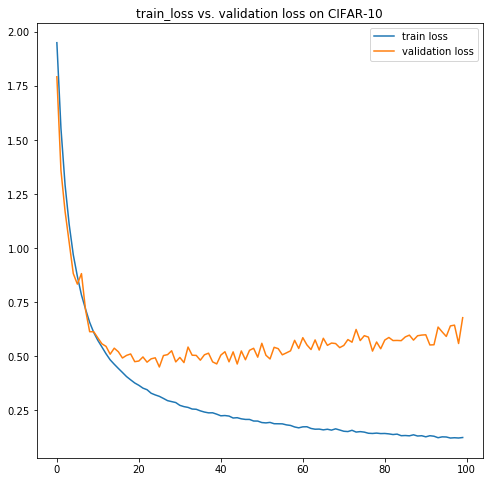

In [63]:
# Plot the training loss
plt.plot(history.history['loss'], label='train loss');
# Plot the validation loss
plt.plot(history.history['val_loss'], label='validation loss');
plt.title('train_loss vs. validation loss on CIFAR-10')
plt.legend();

## Model Inference

In [64]:
# Load the weights and test it with test data
model_l = allcnn(weights='best_weights.hdf5')
model_l.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

print(model_l.summary())

scores = model_l.evaluate(X_test, y_test, verbose=1)
print('Accuracy: {}'.format(scores[1]))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 32, 32, 96)        2688      
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 32, 96)        83040     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 16, 16, 96)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 16, 16, 192)       331968    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 8, 8, 192)        

In [69]:
# make dictionary of class labels
classes = range(0, 10)

# zip the names and labels to make a dictionary of class labels
class_labels = dict(zip(classes, labels))
print(class_labels)

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


In [70]:
# Generate batch of 9 images to predict
batch = X_test[100:109]
ground_truth = np.argmax(y_test[100:109], axis=-1)

# Make predictions
predictions = model.predict(batch, verbose=1)

9/9 [==============================] - 0s 3ms/sample


In [72]:
# use np.argmax)_ tp cpmvert class probabilities to class labels
class_result = np.argmax(predictions, axis=-1)
class_result

array([4, 5, 6, 3, 1, 1, 3, 6, 8], dtype=int64)

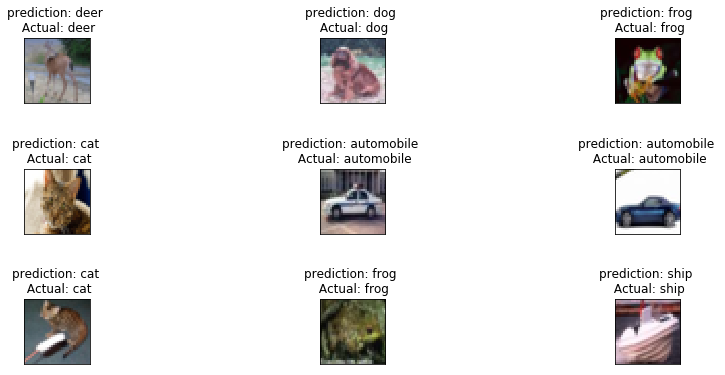

In [74]:
# Create a grid of 3x3 images
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
fig.subplots_adjust(hspace=1)
axs = axs.flatten()

for i, img in enumerate(batch):
    # Determine label for each prediction, set title
    for key, value in class_labels.items():
        if class_result[i] == key:
            title = 'prediction: {} \n Actual: {}'.format(class_labels[key], class_labels[ground_truth[i]])
            axs[i].set_title(title)
            axs[i].axes.get_xaxis().set_visible(False)
            axs[i].axes.get_yaxis().set_visible(False)
            
    # Plot the image
    axs[i].imshow(img)